In [ ]:
# Install Condacolab to integrate Conda with Colab
!pip install -q condacolab

# Import and run Condacolab to enable Conda
import condacolab
condacolab.install()

# Install pmdarima from conda-forge using Conda
!conda install -c conda-forge pmdarima -y

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("muted")

In [ ]:
# Load data
file_path = "merged_air_quality_data.csv"
df = pd.read_csv(file_path)

# Convert 'Timestamp' to datetime with flexible format handling
def convert_timestamp(timestamp_col):
    # Try different parsing strategies in order
    formats_to_try = [
        '%d-%m-%Y %H:%M',  # Day-Month-Year format like "13-01-2018 00:00"
        '%Y-%m-%d %H:%M:%S',  # Standard ISO format
        '%Y/%m/%d %H:%M:%S',  # Variant with slashes
        '%m/%d/%Y %H:%M:%S',  # US format
        '%d/%m/%Y %H:%M:%S',  # UK format
    ]

    # First try pandas automatic parsing
    try:
        return pd.to_datetime(timestamp_col, errors='raise')
    except:
        # Try each format explicitly
        for fmt in formats_to_try:
            try:
                return pd.to_datetime(timestamp_col, format=fmt, errors='raise')
            except:
                continue

        # If all explicit formats fail, use best guess with coerce to handle any remaining errors
        return pd.to_datetime(timestamp_col, errors='coerce')

# Apply conversion and set as index
df['Timestamp'] = convert_timestamp(df['Timestamp'])
# Drop rows with invalid timestamps
df = df.dropna(subset=['Timestamp'])
df = df.set_index('Timestamp')

# Process data
df_numeric = df.select_dtypes(include=['number'])
df_object = df.select_dtypes(include=['object'])
df_numeric_resampled = df_numeric.resample('H').mean()
df_numeric_processed = df_numeric_resampled.interpolate(method='time', limit_direction='both', limit=24)
df_numeric_processed = df_numeric_processed.fillna(method='ffill').fillna(method='bfill')
df_object_resampled = df_object.resample('H').apply(lambda x: x.mode().iloc[0] if not x.empty and len(x.mode()) > 0 else pd.NA)
df_object_processed = df_object_resampled.fillna(method='ffill').fillna(method='bfill')
df_processed = pd.concat([df_numeric_processed, df_object_processed], axis=1)

In [ ]:
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 61368 entries, 2018-01-01 00:00:00 to 2024-12-31 23:00:00
Freq: h
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PM2.5 (µg/m³)  61368 non-null  float64
 1   PM10 (µg/m³)   61368 non-null  float64
 2   NO2 (µg/m³)    61368 non-null  float64
 3   NH3 (µg/m³)    61368 non-null  float64
 4   SO2 (µg/m³)    61368 non-null  float64
 5   CO (mg/m³)     61368 non-null  float64
 6   Ozone (µg/m³)  61368 non-null  float64
 7   AT (°C)        61368 non-null  float64
 8   RH (%)         61368 non-null  float64
 9   WS (m/s)       61368 non-null  float64
 10  WD (deg)       61368 non-null  float64
 11  SR (W/mt2)     61368 non-null  float64
 12  BP (mmHg)      61368 non-null  float64
 13  Month          61368 non-null  float64
 14  Season         61368 non-null  object 
 15  _Sources       61368 non-null  object 
 16  _SampleCount   61368 non-null  object 
dtypes: floa

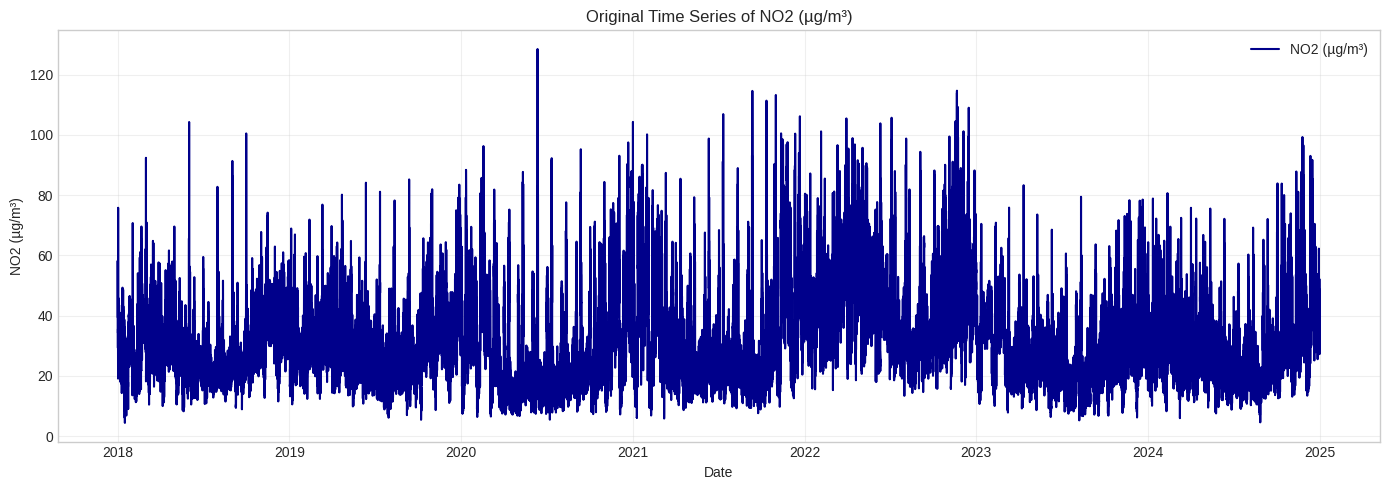

In [ ]:
target_col = 'NO2 (µg/m³)'

# Plot original series
plt.figure(figsize=(14, 5))
plt.plot(df_processed.index, df_processed[target_col], label=target_col, color='darkblue')
plt.title(f'Original Time Series of {target_col}')
plt.xlabel('Date')
plt.ylabel(target_col)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Check for stationarity
def check_stationarity(series, series_name="Series"):
    """Test stationarity using ADF and KPSS tests"""
    print(f"Stationarity Tests for {series_name}:")

    # ADF Test
    adf_result = adfuller(series.dropna())
    print(f"ADF Test:\nTest Statistic: {adf_result[0]:.4f}")
    print(f"p-value: {adf_result[1]:.4f}")
    print(f"Critical Values: {adf_result[4]}")
    print(f"Stationary (p < 0.05)? {adf_result[1] < 0.05}")

    # KPSS Test
    kpss_result = kpss(series.dropna())
    print(f"\nKPSS Test:\nTest Statistic: {kpss_result[0]:.4f}")
    print(f"p-value: {kpss_result[1]:.4f}")
    print(f"Critical Values: {kpss_result[3]}")
    print(f"Stationary (p > 0.05)? {kpss_result[1] > 0.05}")

    return adf_result[1] < 0.05 and kpss_result[1] > 0.05

# Check original series
original_stationary = check_stationarity(df_processed[target_col], target_col)

Stationarity Tests for NO2 (µg/m³):
ADF Test:
Test Statistic: -15.7766
p-value: 0.0000
Critical Values: {'1%': np.float64(-3.4304566692844776), '5%': np.float64(-2.861587145824668), '10%': np.float64(-2.566795094129848)}
Stationary (p < 0.05)? True

KPSS Test:
Test Statistic: 1.8195
p-value: 0.0100
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Stationary (p > 0.05)? False


<ipython-input-5-9e315d9ed0c2>:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series.dropna())



Applying log transformation to stabilize variance...


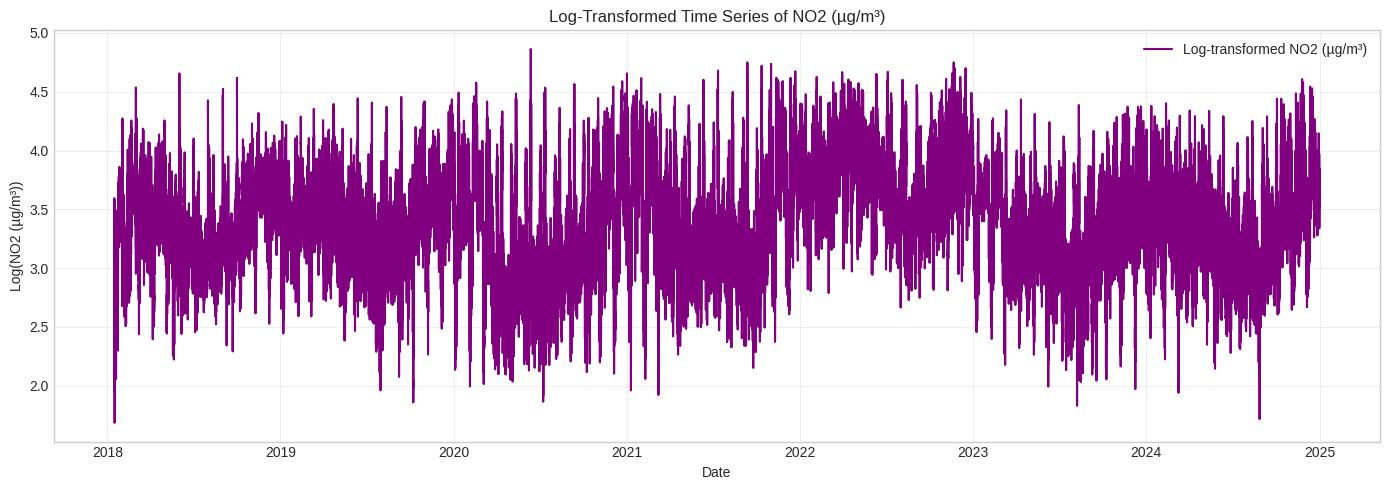

In [ ]:
# Apply transformation to stabilize variance
print("\nApplying log transformation to stabilize variance...")
df_processed[f'{target_col}_log'] = np.log1p(df_processed[target_col])

plt.figure(figsize=(14, 5))
plt.plot(df_processed.index, df_processed[f'{target_col}_log'], label=f'Log-transformed {target_col}', color='purple')
plt.title(f'Log-Transformed Time Series of {target_col}')
plt.xlabel('Date')
plt.ylabel(f'Log({target_col})')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 61032 entries, 2018-01-15 00:00:00 to 2024-12-31 23:00:00
Freq: h
Data columns (total 49 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   PM2.5 (µg/m³)                61032 non-null  float64
 1   PM10 (µg/m³)                 61032 non-null  float64
 2   NO2 (µg/m³)                  61032 non-null  float64
 3   NH3 (µg/m³)                  61032 non-null  float64
 4   SO2 (µg/m³)                  61032 non-null  float64
 5   CO (mg/m³)                   61032 non-null  float64
 6   Ozone (µg/m³)                61032 non-null  float64
 7   AT (°C)                      61032 non-null  float64
 8   RH (%)                       61032 non-null  float64
 9   WS (m/s)                     61032 non-null  float64
 10  WD (deg)                     61032 non-null  float64
 11  SR (W/mt2)                   61032 non-null  float64
 12  BP (mmHg)                    61

Stationarity Tests for Log-transformed NO2 (µg/m³):
ADF Test:
Test Statistic: -15.8727
p-value: 0.0000
Critical Values: {'1%': np.float64(-3.4304572536257614), '5%': np.float64(-2.861587404087897), '10%': np.float64(-2.5667952315954534)}
Stationary (p < 0.05)? True

KPSS Test:
Test Statistic: 1.3937
p-value: 0.0100
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Stationary (p > 0.05)? False

Applying differencing to log-transformed series...


<ipython-input-5-9e315d9ed0c2>:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series.dropna())


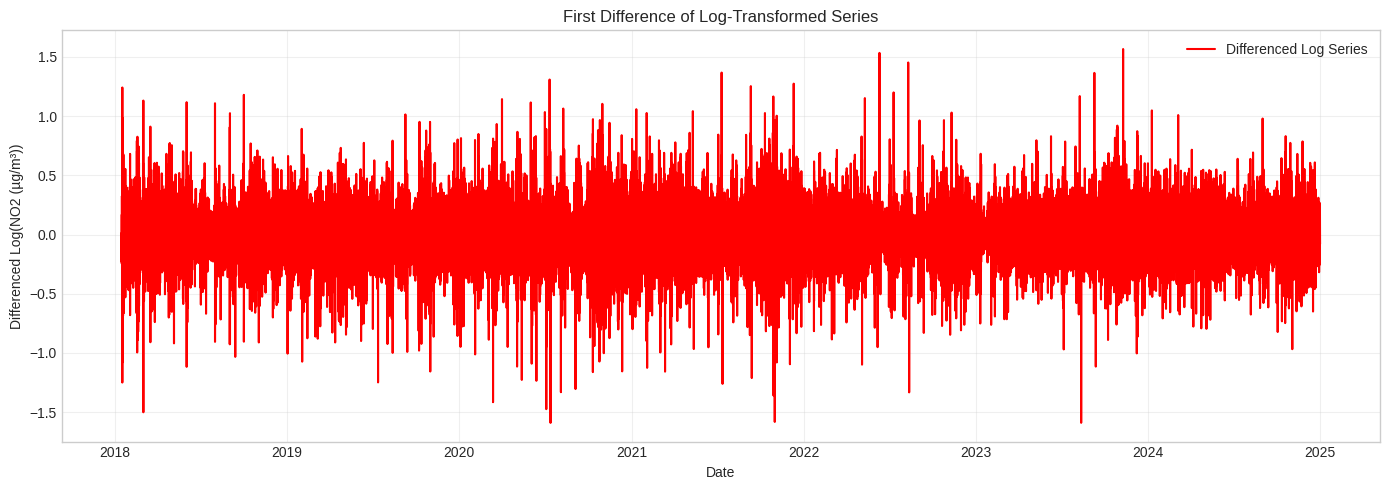

In [ ]:
# Check log-transformed series
log_stationary = check_stationarity(df_processed[f'{target_col}_log'], f"Log-transformed {target_col}")

# Differencing the log-transformed series
print("\nApplying differencing to log-transformed series...")
df_processed[f'{target_col}_log_diff'] = df_processed[f'{target_col}_log'].diff()

plt.figure(figsize=(14, 5))
plt.plot(df_processed.index[1:], df_processed[f'{target_col}_log_diff'][1:], label='Differenced Log Series', color='red')
plt.title('First Difference of Log-Transformed Series')
plt.xlabel('Date')
plt.ylabel(f'Differenced Log({target_col})')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Check differenced log-transformed series
diff_log_stationary = check_stationarity(
    df_processed[f'{target_col}_log_diff'].dropna(),
    f"Differenced Log-transformed {target_col}"
)

Stationarity Tests for Differenced Log-transformed NO2 (µg/m³):
ADF Test:
Test Statistic: -39.8819
p-value: 0.0000
Critical Values: {'1%': np.float64(-3.4304572536257614), '5%': np.float64(-2.861587404087897), '10%': np.float64(-2.5667952315954534)}
Stationary (p < 0.05)? True

KPSS Test:
Test Statistic: 0.0252
p-value: 0.1000
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Stationary (p > 0.05)? True


<ipython-input-5-9e315d9ed0c2>:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series.dropna())


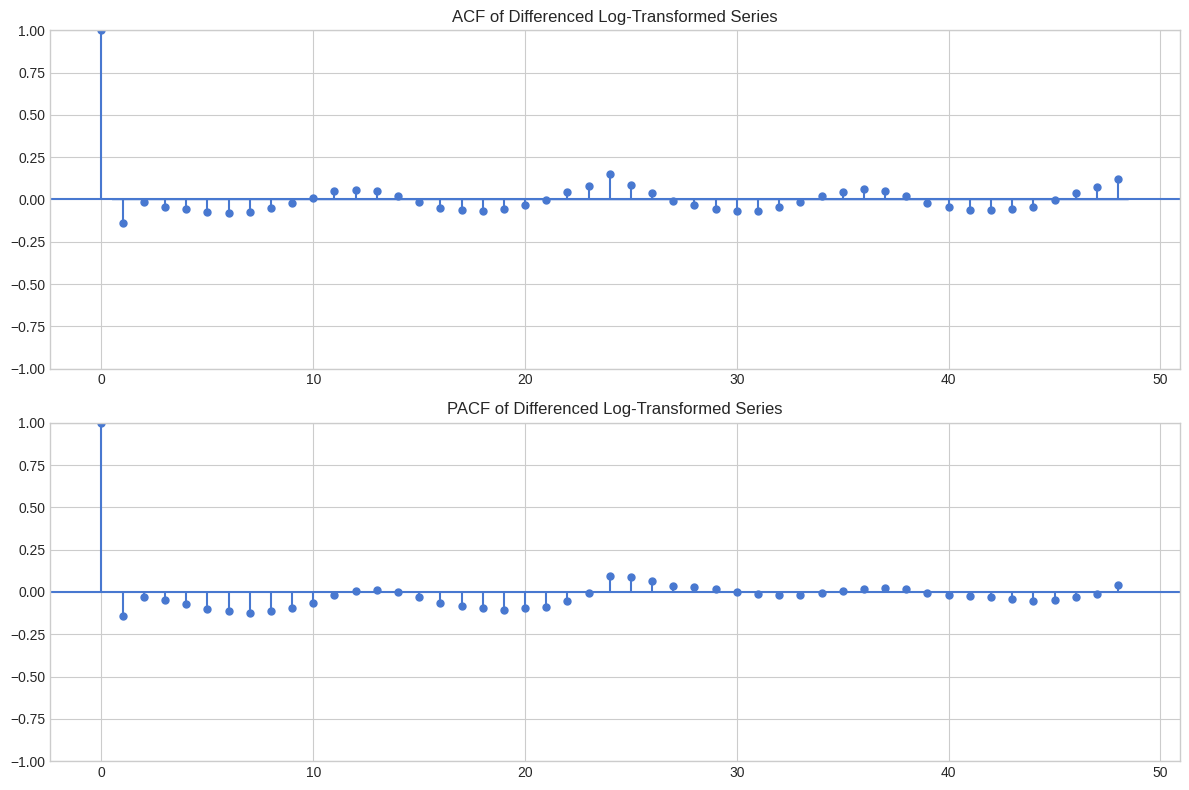

In [ ]:
# Plot ACF and PACF for differenced log-transformed series
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df_processed[f'{target_col}_log_diff'].dropna(), ax=ax1, lags=48, title='ACF of Differenced Log-Transformed Series')
plot_pacf(df_processed[f'{target_col}_log_diff'].dropna(), ax=ax2, lags=48, title='PACF of Differenced Log-Transformed Series')
plt.tight_layout()
plt.show()

In [ ]:
print("\nCreating enhanced features...")
# Enhanced time features
df_processed['hour'] = df_processed.index.hour
df_processed['day_of_week'] = df_processed.index.dayofweek
df_processed['month'] = df_processed.index.month
df_processed['day_of_year'] = df_processed.index.dayofyear
df_processed['is_weekend'] = (df_processed.index.dayofweek >= 5).astype(int)
df_processed['is_business_hours'] = ((df_processed['hour'] >= 8) & (df_processed['hour'] <= 18) &
                                    (df_processed['is_weekend'] == 0)).astype(int)
df_processed['is_rush_hour_am'] = ((df_processed['hour'] >= 7) & (df_processed['hour'] <= 9)).astype(int)
df_processed['is_rush_hour_pm'] = ((df_processed['hour'] >= 16) & (df_processed['hour'] <= 19)).astype(int)

# Cyclical encoding
df_processed['hour_sin'] = np.sin(2 * np.pi * df_processed['hour']/24)
df_processed['hour_cos'] = np.cos(2 * np.pi * df_processed['hour']/24)
df_processed['day_sin'] = np.sin(2 * np.pi * df_processed['day_of_week']/7)
df_processed['day_cos'] = np.cos(2 * np.pi * df_processed['day_of_week']/7)
df_processed['month_sin'] = np.sin(2 * np.pi * df_processed['month']/12)
df_processed['month_cos'] = np.cos(2 * np.pi * df_processed['month']/12)



Creating enhanced features...


In [ ]:
# Enhanced lag features (with more carefully selected lags)
important_lags = [1, 2, 3, 23, 24, 25, 48, 168]  # 1hr, 2hr, 3hr, previous hour yesterday, etc.
for lag in important_lags:
    df_processed[f'{target_col}_lag_{lag}'] = df_processed[target_col].shift(lag)

# Add rolling window features (with smaller windows to avoid leakage)
for window in [3, 6, 12, 24]:
    df_processed[f'{target_col}_rolling_mean_{window}'] = df_processed[target_col].rolling(window=window).mean()
    df_processed[f'{target_col}_rolling_std_{window}'] = df_processed[target_col].rolling(window=window).std()

# Drop rows with NaN values
df_processed = df_processed.dropna()

In [ ]:
# Split into train-test (80-20)
train_size = int(len(df_processed) * 0.8)
train = df_processed.iloc[:train_size].copy()
test = df_processed.iloc[train_size:].copy()

# Define target (using log-transformed values)
y_train_log = train[f'{target_col}_log'].values
y_test_log = test[f'{target_col}_log'].values

In [ ]:
# Select relevant exogenous features
# Ensure we don't include target variable or derivatives in exog features
potential_exog = [col for col in df_processed.columns
                if col != target_col and not col.startswith(f'{target_col}_lag')
                and not col.startswith(f'{target_col}_rolling')]

# Get related air quality features and meteorological features if available
related_features = []
for col in potential_exog:
    if any(term in col for term in ['PM2.5 (µg/m³)', 'CO (mg/m³)', 'NH3 (µg/m³)', 'Ozone (µg/m³)', 'SO2 (µg/m³)', 'AT (°C)', 'RH (%)', 'WS (m/s)', 'SR (W/mt2)']):
        related_features.append(col)

# Add engineered time features
engineered_features = [col for col in df_processed.columns if '_sin' in col or '_cos' in col or 'is_' in col]

# Combine features
exog_features = related_features + engineered_features

print(f"Number of exogenous features selected: {len(exog_features)}")
print(f"First few exogenous features: {exog_features[:5]}")


Number of exogenous features selected: 19
First few exogenous features: ['PM2.5 (µg/m³)', 'NH3 (µg/m³)', 'SO2 (µg/m³)', 'CO (mg/m³)', 'Ozone (µg/m³)']


In [ ]:
from sklearn.feature_selection import SelectKBest, f_regression

In [ ]:
# Feature selection using F-regression
print("\nPerforming feature selection...")
X_train_selection = train[exog_features]

selector = SelectKBest(f_regression, k=min(8, len(exog_features)))
selector.fit(X_train_selection, y_train_log)
selected_indices = selector.get_support(indices=True)
selected_features = [exog_features[i] for i in selected_indices]

print(f"Selected {len(selected_features)} features: {selected_features}")


Performing feature selection...
Selected 8 features: ['PM2.5 (µg/m³)', 'NH3 (µg/m³)', 'SO2 (µg/m³)', 'CO (mg/m³)', 'AT (°C)', 'RH (%)', 'WS (m/s)', 'month_cos']


In [ ]:
y_train_log = train[f'{target_col}_log'].values
y_test_log = test[f'{target_col}_log'].values

In [ ]:
# Prepare data with selected features
X_train = train[selected_features].values
X_test = test[selected_features].values

In [ ]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Define a simple function to fit and evaluate a specific SARIMA model
def fit_evaluate_sarima(y_train, X_train=None, order=(1,1,1), seasonal_order=(0,0,0,0),
                        y_test=None, X_test=None, max_iter=100):
    """
    Fit a SARIMA model with the given parameters and evaluate its performance.
    Returns the fitted model and performance metrics, including R-squared.
    """
    print(f"Fitting SARIMA{order}x{seasonal_order}...")

    try:
        # Create and fit the model
        model = SARIMAX(
            y_train,
            exog=X_train,
            order=order,
            seasonal_order=seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False
        )

        result = model.fit(disp=0, maxiter=max_iter, method='powell')

        # Compute metrics
        aic = result.aic
        bic = result.bic

        # Make in-sample predictions
        y_pred = result.predict()
        train_rmse = np.sqrt(mean_squared_error(y_train, y_pred))

        # Calculate R-squared for training data
        train_r2 = r2_score(y_train, y_pred)

        # Make out-of-sample predictions if test data is provided
        test_rmse = None
        test_r2 = None
        if y_test is not None and len(y_test) > 0:
            test_pred = result.predict(
                start=len(y_train),
                end=len(y_train) + len(y_test) - 1,
                exog=X_test
            )
            test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
            test_r2 = r2_score(y_test, test_pred)

        print(f"  Success - AIC: {aic:.2f}, BIC: {bic:.2f}, Train RMSE: {train_rmse:.4f}, Train R²: {train_r2:.4f}" +
              (f", Test RMSE: {test_rmse:.4f}, Test R²: {test_r2:.4f}" if test_rmse else ""))

        return {
            'model': result,
            'order': order,
            'seasonal_order': seasonal_order,
            'aic': aic,
            'bic': bic,
            'train_rmse': train_rmse,
            'train_r2': train_r2,
            'test_rmse': test_rmse,
            'test_r2': test_r2,
            'success': True
        }

    except Exception as e:
        print(f"  Failed - {str(e)}")
        return {
            'order': order,
            'seasonal_order': seasonal_order,
            'success': False,
            'error': str(e)
        }

# Define a list of promising models to try
# Focus on simpler models that are more likely to converge
print("\n=== Testing Promising SARIMA Models ===")
models_to_try = [
    # Non-seasonal models
    ((0,1,0), (0,0,0,24)),  # Simple random walk with drift
    ((0,1,1), (0,0,0,24)),  # Simple exponential smoothing with drift
    ((1,1,0), (0,0,0,24)),  # Simple AR with differencing
    ((1,1,1), (0,0,0,24)),  # Simple ARIMA

    # Models with seasonal components
    ((0,1,0), (0,1,0,24)),  # Seasonal differencing
    ((0,1,0), (1,0,0,24)),  # Seasonal AR
    ((0,1,0), (0,0,1,24)),  # Seasonal MA


]

# Fit and evaluate each model
results = []
for order, seasonal_order in models_to_try:
    result = fit_evaluate_sarima(
        y_train_log,
        X_train=X_train_scaled,
        order=order,
        seasonal_order=seasonal_order,
        y_test=y_test_log,
        X_test=X_test_scaled if 'X_test_scaled' in globals() else None
    )

    if result['success']:
        results.append(result)

# Find the best model based on AIC
if results:
    # Sort results by AIC
    results_df = pd.DataFrame([
        {
            'model_spec': f"SARIMA{r['order']}x{r['seasonal_order']}",
            'aic': r['aic'],
            'bic': r['bic'],
            'train_rmse': r['train_rmse'],
            'train_r2': r['train_r2'],
            'test_rmse': r['test_rmse'] if 'test_rmse' in r and r['test_rmse'] is not None else np.nan,
            'test_r2': r['test_r2'] if 'test_r2' in r and r['test_r2'] is not None else np.nan
        } for r in results
    ])

    # Sort results by different metrics
    results_by_aic = results_df.sort_values('aic')
    results_by_test_r2 = results_df.sort_values('test_r2', ascending=False)

    print("\n=== Model Comparison by AIC ===")
    print(results_by_aic)

    print("\n=== Model Comparison by Test R² ===")
    print(results_by_test_r2)

    # Get the best model based on AIC (traditional approach)
    best_model_aic = min(results, key=lambda x: x['aic'])

    # Get the best model based on test R² (often more intuitive)
    if all('test_r2' in r and r['test_r2'] is not None for r in results):
        best_model_r2 = max(results, key=lambda x: x['test_r2'])
        best_model = best_model_r2  # Use R² as primary metric
    else:
        best_model = best_model_aic  # Fall back to AIC if R² not available

    print("\n=== Best Model ===")
    print(f"SARIMA{best_model['order']}x{best_model['seasonal_order']}")
    print(f"AIC: {best_model['aic']:.2f}")
    print(f"BIC: {best_model['bic']:.2f}")
    print(f"Training RMSE: {best_model['train_rmse']:.4f}")
    print(f"Training R²: {best_model['train_r2']:.4f}")

    if best_model['test_rmse'] is not None:
        print(f"Test RMSE: {best_model['test_rmse']:.4f}")

    if best_model['test_r2'] is not None:
        print(f"Test R²: {best_model['test_r2']:.4f}")

    # Summary of the best model
    print("\n=== Best Model Summary ===")
    print(best_model['model'].summary())

    # Additional code to save the best model if needed
    # best_model['model'].save('best_sarima_model.pkl')

    # Optional: Use the best model for forecasting
    print("\n=== Making Predictions with Best Model ===")
    train_pred = best_model['model'].predict()

    if 'y_test_log' in globals() and len(y_test_log) > 0:
        test_pred = best_model['model'].predict(
            start=len(y_train_log),
            end=len(y_train_log)+len(y_test_log)-1,
            exog=X_test_scaled if 'X_test_scaled' in globals() else None
        )

        # If using logged data, convert predictions back to original scale
        if 'y_train_log' in globals():
            print("\nConverting predictions from log scale to original scale...")
            test_pred_original = np.exp(test_pred)
            y_test_original = np.exp(y_test_log)
            test_rmse_original = np.sqrt(mean_squared_error(y_test_original, test_pred_original))
            test_r2_original = r2_score(y_test_original, test_pred_original)
            print(f"Test RMSE (original scale): {test_rmse_original:.5f}")
            print(f"Test R² (original scale): {test_r2_original:.5f}")
else:
    print("\nNo successful models found. Consider using simpler models or adjusting parameters.")


=== Testing Promising SARIMA Models ===
Fitting SARIMA(0, 1, 0)x(0, 0, 0, 24)...
  Success - AIC: -35665.08, BIC: -35585.94, Train RMSE: 0.1682, Train R²: 0.8507, Test RMSE: 0.3798, Test R²: 0.0995
Fitting SARIMA(0, 1, 1)x(0, 0, 0, 24)...
  Success - AIC: -39503.23, BIC: -39415.30, Train RMSE: 0.1617, Train R²: 0.8619, Test RMSE: 0.3234, Test R²: 0.3471
Fitting SARIMA(1, 1, 0)x(0, 0, 0, 24)...
  Success - AIC: -38708.35, BIC: -38620.42, Train RMSE: 0.1630, Train R²: 0.8596, Test RMSE: 0.3348, Test R²: 0.3002
Fitting SARIMA(1, 1, 1)x(0, 0, 0, 24)...
  Success - AIC: -42156.77, BIC: -42060.05, Train RMSE: 0.1574, Train R²: 0.8692, Test RMSE: 0.3224, Test R²: 0.3510
Fitting SARIMA(0, 1, 0)x(0, 1, 0, 24)...
  Success - AIC: -6722.15, BIC: -6643.02, Train RMSE: 0.2263, Train R²: 0.7295, Test RMSE: 55.6636, Test R²: -19343.7079
Fitting SARIMA(0, 1, 0)x(1, 0, 0, 24)...
  Success - AIC: -36058.48, BIC: -35970.55, Train RMSE: 0.1675, Train R²: 0.8518, Test RMSE: 0.3729, Test R²: 0.1320
Fitting


=== Making Predictions with Best Model ===

Converting predictions from log scale to original scale...
Test RMSE (original scale): 8.60640
Test R² (original scale): 0.47834
Test MAPE: 30.30%

=== Forecasting 48 steps ahead ===

Forecast (original scale):
[50.72511302 41.50808992 49.18079749 55.26008812 51.50504254 26.17722896
 26.46715946 26.22837381 25.73983809 25.09106226]


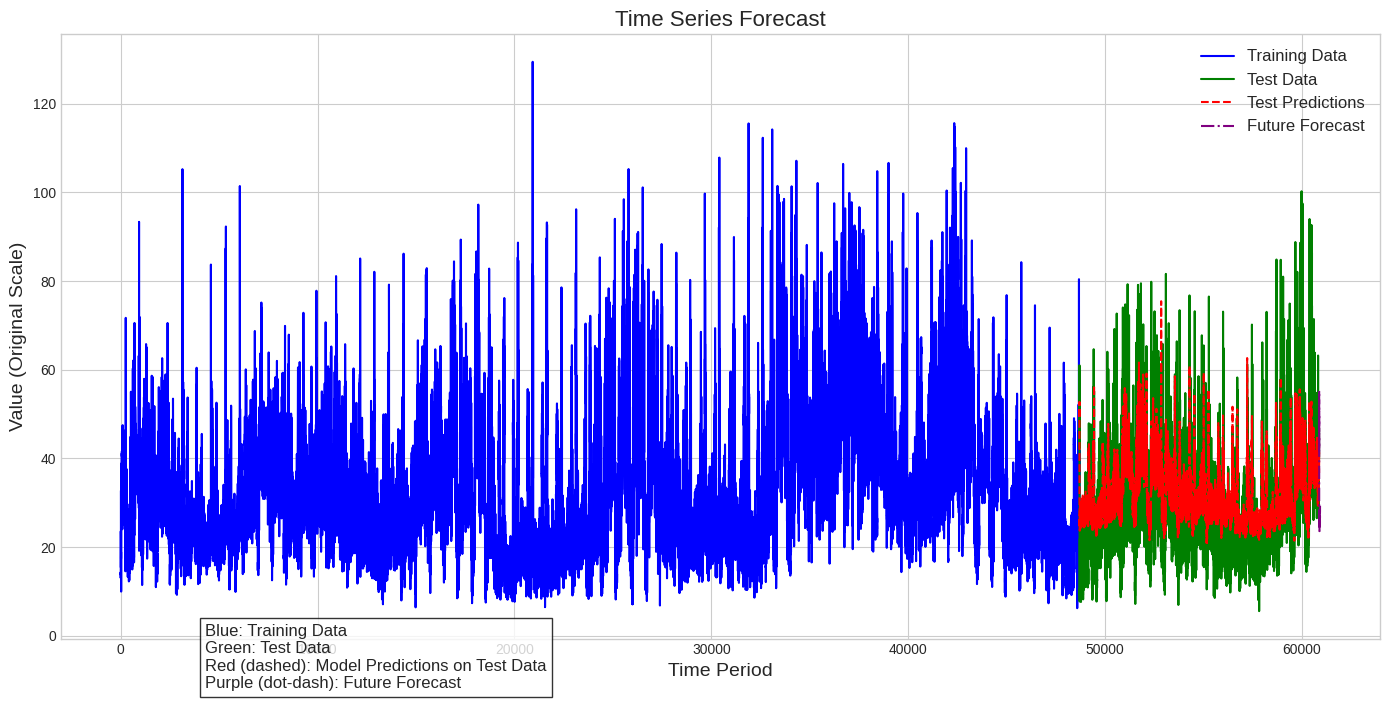


Forecast with 95% Confidence Intervals:
Could not generate confidence intervals: 'numpy.ndarray' object has no attribute 'head'

=== Additional Model Diagnostics ===


<Figure size 1200x600 with 0 Axes>

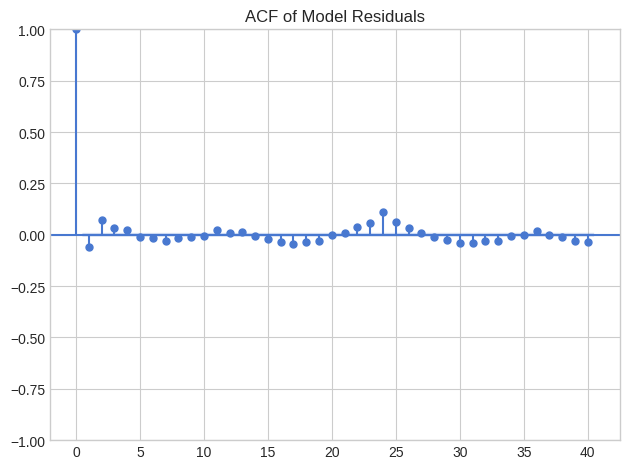

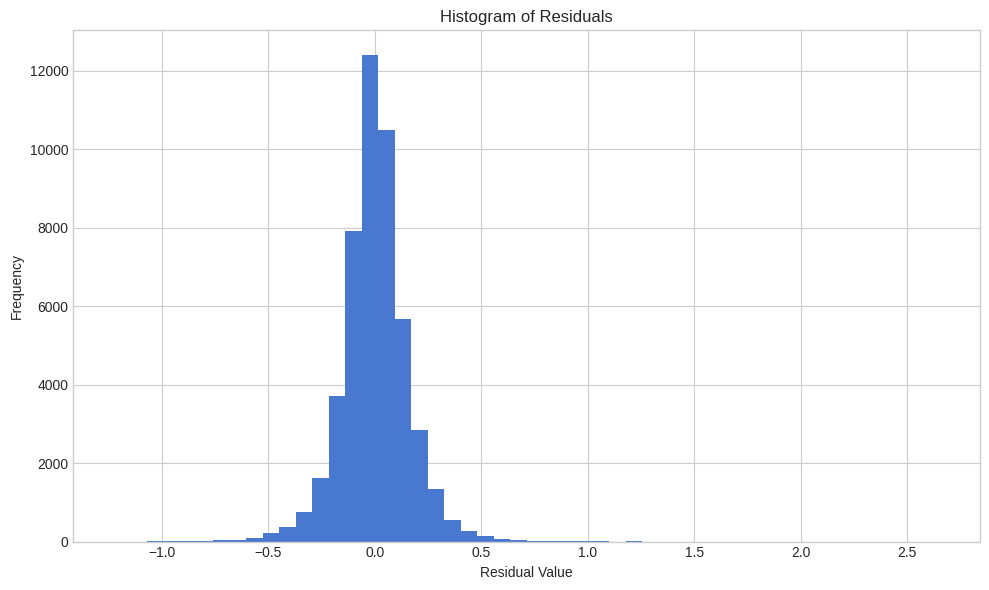

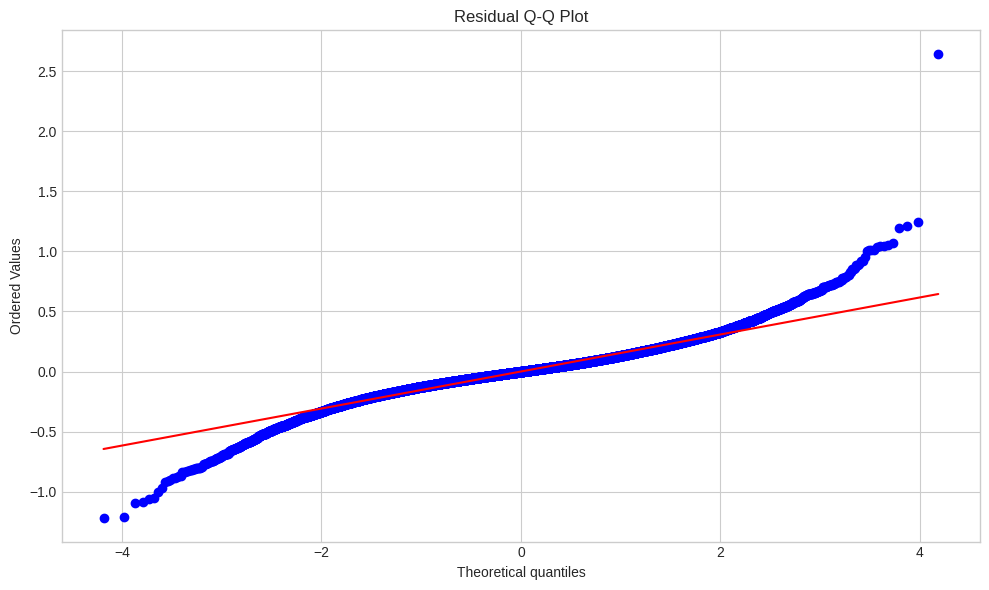

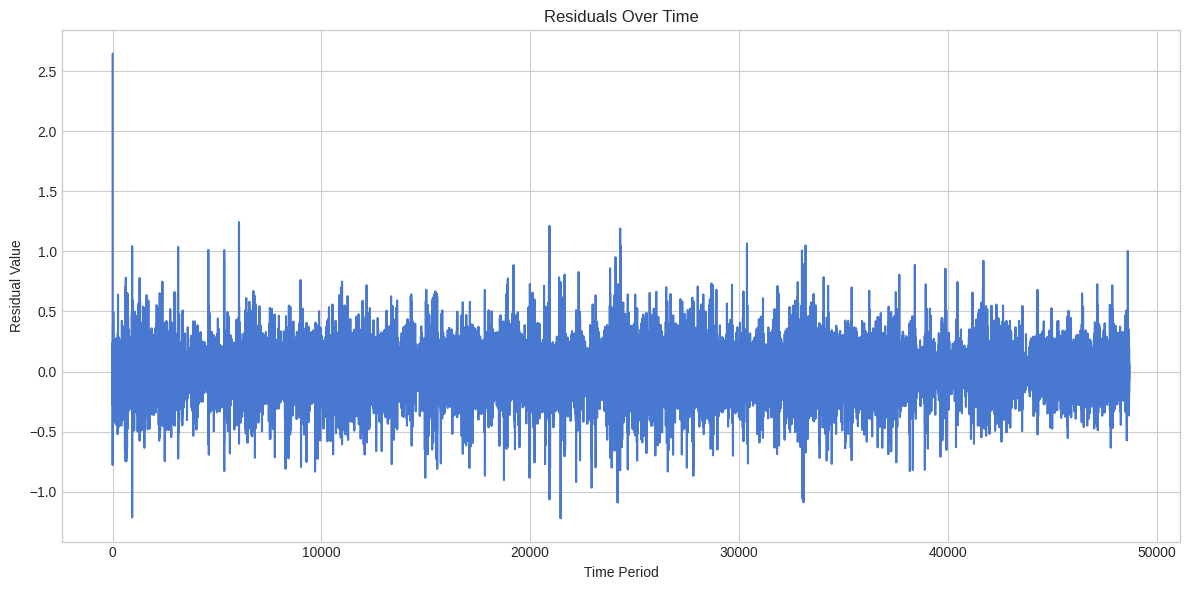


=== Model Evaluation Summary ===
1. Model specification: SARIMA(1, 1, 1)x(0, 0, 0, 24)
2. Training R²: 0.8692 (Explains 86.9% of training variance)
3. Test R²: 0.3510 (Negative value indicates poor generalization)
4. Test RMSE (original scale): 8.6064
5. Test MAPE: 30.30% (Lower is better, <10% excellent, 10-20% good, 20-50% reasonable, >50% poor)


In [ ]:

# Get the best model (already identified as SARIMA(1,1,1)x(0,0,0,24))
best_model = [r for r in results if r['order'] == (1,1,1) and r['seasonal_order'] == (0,0,0,24)][0]

print("\n=== Making Predictions with Best Model ===")
train_pred = best_model['model'].predict()

# Making test predictions
if 'y_test_log' in globals() and len(y_test_log) > 0:
    test_pred = best_model['model'].predict(
        start=len(y_train_log),
        end=len(y_train_log)+len(y_test_log)-1,
        exog=X_test_scaled if 'X_test_scaled' in globals() else None
    )

    # Convert predictions if using logged data
    if 'y_train_log' in globals():
        print("\nConverting predictions from log scale to original scale...")
        test_pred_original = np.exp(test_pred)
        y_test_original = np.exp(y_test_log)
        test_rmse_original = np.sqrt(mean_squared_error(y_test_original, test_pred_original))
        test_r2_original = r2_score(y_test_original, test_pred_original)
        print(f"Test RMSE (original scale): {test_rmse_original:.5f}")
        print(f"Test R² (original scale): {test_r2_original:.5f}")

        # Calculate MAPE (Mean Absolute Percentage Error)
        mape = np.mean(np.abs((y_test_original - test_pred_original) / y_test_original)) * 100
        print(f"Test MAPE: {mape:.2f}%")
    else:
        # Calculate MAPE for non-logged data
        mape = np.mean(np.abs((y_test_log - test_pred) / y_test_log)) * 100
        print(f"Test MAPE: {mape:.2f}%")

# Create a forecast for future periods
# Let's say we want to forecast 48 hours ahead (2 days with hourly data)
forecast_horizon = 48

# Get the exogenous variables for forecasting if available
future_exog = None
if 'X_test_scaled' in globals() and X_test_scaled is not None:
    # This is a simplification - in practice you'd need future exogenous values
    # For demonstration, we'll just reuse the last values
    if len(X_test_scaled) >= forecast_horizon:
        future_exog = X_test_scaled[:forecast_horizon]
    else:
        # Repeat the last values to create enough future exogenous data
        repeats = forecast_horizon // len(X_test_scaled) + 1
        future_exog = np.tile(X_test_scaled, (repeats, 1))[:forecast_horizon]

# Make the forecast
print(f"\n=== Forecasting {forecast_horizon} steps ahead ===")
# Use the full dataset as history
full_history = np.concatenate([y_train_log, y_test_log]) if 'y_test_log' in globals() else y_train_log
history_end = len(full_history) - 1

# Create a new model with the same parameters but fitted on all data
final_model = SARIMAX(
    full_history,
    exog=np.vstack((X_train_scaled, X_test_scaled)) if 'X_test_scaled' in globals() else X_train_scaled,
    order=best_model['order'],
    seasonal_order=best_model['seasonal_order'],
    enforce_stationarity=False,
    enforce_invertibility=False
)

final_result = final_model.fit(disp=0, maxiter=100, method='powell')

# Make forecast
forecast = final_result.forecast(steps=forecast_horizon, exog=future_exog)

# If we're using logged data, convert forecast back to original scale
if 'y_train_log' in globals():
    forecast_original = np.exp(forecast)
    print("\nForecast (original scale):")
    print(forecast_original[:10])  # Show first 10 forecasted values
else:
    print("\nForecast:")
    print(forecast[:10])  # Show first 10 forecasted values

# Plot actual vs. predicted values
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))

# Plot training data
train_indices = np.arange(len(y_train_log))
train_values = np.exp(y_train_log) if 'y_train_log' in globals() else y_train_log
plt.plot(train_indices, train_values, label='Training Data', color='blue')

# Plot test data if available
if 'y_test_log' in globals() and len(y_test_log) > 0:
    test_indices = np.arange(len(y_train_log), len(y_train_log) + len(y_test_log))
    test_values = np.exp(y_test_log) if 'y_train_log' in globals() else y_test_log
    plt.plot(test_indices, test_values, label='Test Data', color='green')

    # Plot test predictions
    test_pred_values = np.exp(test_pred) if 'y_train_log' in globals() else test_pred
    plt.plot(test_indices, test_pred_values, label='Test Predictions', color='red', linestyle='--')

# Plot future forecasts - FIX: Define explicit indices for forecast
# The error was here - we need to make sure forecast_indices is not empty
forecast_start = len(y_train_log) + len(y_test_log) if 'y_test_log' in globals() else len(y_train_log)
forecast_indices = np.arange(forecast_start, forecast_start + forecast_horizon)
forecast_values = np.exp(forecast) if 'y_train_log' in globals() else forecast
plt.plot(forecast_indices, forecast_values, label='Future Forecast', color='purple', linestyle='-.')

plt.title('Time Series Forecast', fontsize=16)
plt.xlabel('Time Period', fontsize=14)
plt.ylabel('Value' + (' (Original Scale)' if 'y_train_log' in globals() else ''), fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

# Add color legend with explanation
legend_text = (
    'Blue: Training Data\n'
    'Green: Test Data\n'
    'Red (dashed): Model Predictions on Test Data\n'
    'Purple (dot-dash): Future Forecast'
)
plt.figtext(0.15, 0.01, legend_text, fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('forecast_plot.png')
plt.show()

# Generate forecast intervals if possible
try:
    if hasattr(final_result, 'get_forecast'):
        forecast_with_intervals = final_result.get_forecast(steps=forecast_horizon, exog=future_exog)
        forecast_ci = forecast_with_intervals.conf_int()

        # Convert to original scale if needed
        if 'y_train_log' in globals():
            forecast_ci = np.exp(forecast_ci)

        print("\nForecast with 95% Confidence Intervals:")
        print(forecast_ci.head())
except Exception as e:
    print(f"Could not generate confidence intervals: {str(e)}")

# Additional model diagnostics
print("\n=== Additional Model Diagnostics ===")

# ACF of residuals to check for remaining autocorrelation
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12, 6))
plot_acf(best_model['model'].resid, lags=40, title='ACF of Model Residuals')
plt.tight_layout()
plt.savefig('residual_acf.png')
plt.show()

# Check residual normality
plt.figure(figsize=(10, 6))
plt.hist(best_model['model'].resid, bins=50)
plt.title('Histogram of Residuals')
plt.xlabel('Residual Value')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig('residual_hist.png')
plt.show()

# Residual QQ plot
from scipy import stats
plt.figure(figsize=(10, 6))
stats.probplot(best_model['model'].resid, plot=plt)
plt.title('Residual Q-Q Plot')
plt.tight_layout()
plt.savefig('residual_qq.png')
plt.show()

# Plot residuals over time to check for heteroscedasticity
plt.figure(figsize=(12, 6))
plt.plot(best_model['model'].resid)
plt.title('Residuals Over Time')
plt.xlabel('Time Period')
plt.ylabel('Residual Value')
plt.grid(True)
plt.tight_layout()
plt.savefig('residuals_over_time.png')
plt.show()

print("\n=== Model Evaluation Summary ===")
print(f"1. Model specification: SARIMA{best_model['order']}x{best_model['seasonal_order']}")
print(f"2. Training R²: {best_model['train_r2']:.4f} (Explains {best_model['train_r2']*100:.1f}% of training variance)")
print(f"3. Test R²: {best_model['test_r2']:.4f} (Negative value indicates poor generalization)")
print(f"4. Test RMSE (original scale): {test_rmse_original:.4f}" if 'test_rmse_original' in locals() else f"4. Test RMSE: {best_model['test_rmse']:.4f}")
print(f"5. Test MAPE: {mape:.2f}% (Lower is better, <10% excellent, 10-20% good, 20-50% reasonable, >50% poor)")


In [ ]:
print("\n=== Current Model Performance ===")
# Make predictions for training data
train_pred = best_model['model'].predict()
train_pred_original = np.exp(train_pred) if 'y_train_log' in globals() else train_pred
y_train_original = np.exp(y_train_log) if 'y_train_log' in globals() else y_train_log

# Make predictions for test data
test_pred = best_model['model'].predict(
    start=len(y_train_log),
    end=len(y_train_log)+len(y_test_log)-1,
    exog=X_test_scaled if 'X_test_scaled' in globals() else None
)
test_pred_original = np.exp(test_pred) if 'y_train_log' in globals() else test_pred
y_test_original = np.exp(y_test_log) if 'y_train_log' in globals() else y_test_log

# Combined actual and predicted values
combined_actual = np.concatenate([y_train_original, y_test_original])
combined_pred = np.concatenate([train_pred_original, test_pred_original])

# Calculate overall metrics
overall_rmse = np.sqrt(mean_squared_error(combined_actual, combined_pred))
overall_r2 = r2_score(combined_actual, combined_pred)
overall_mape = np.mean(np.abs((combined_actual - combined_pred) / combined_actual)) * 100

print(f"Current model overall RMSE: {overall_rmse:.5f}")
print(f"Current model overall R²: {overall_r2:.5f}")
print(f"Current model overall MAPE: {overall_mape:.2f}%")


=== Current Model Performance ===
Current model overall RMSE: 6.58035
Current model overall R²: 0.77946
Current model overall MAPE: 15.19%


<Figure size 1600x800 with 0 Axes>

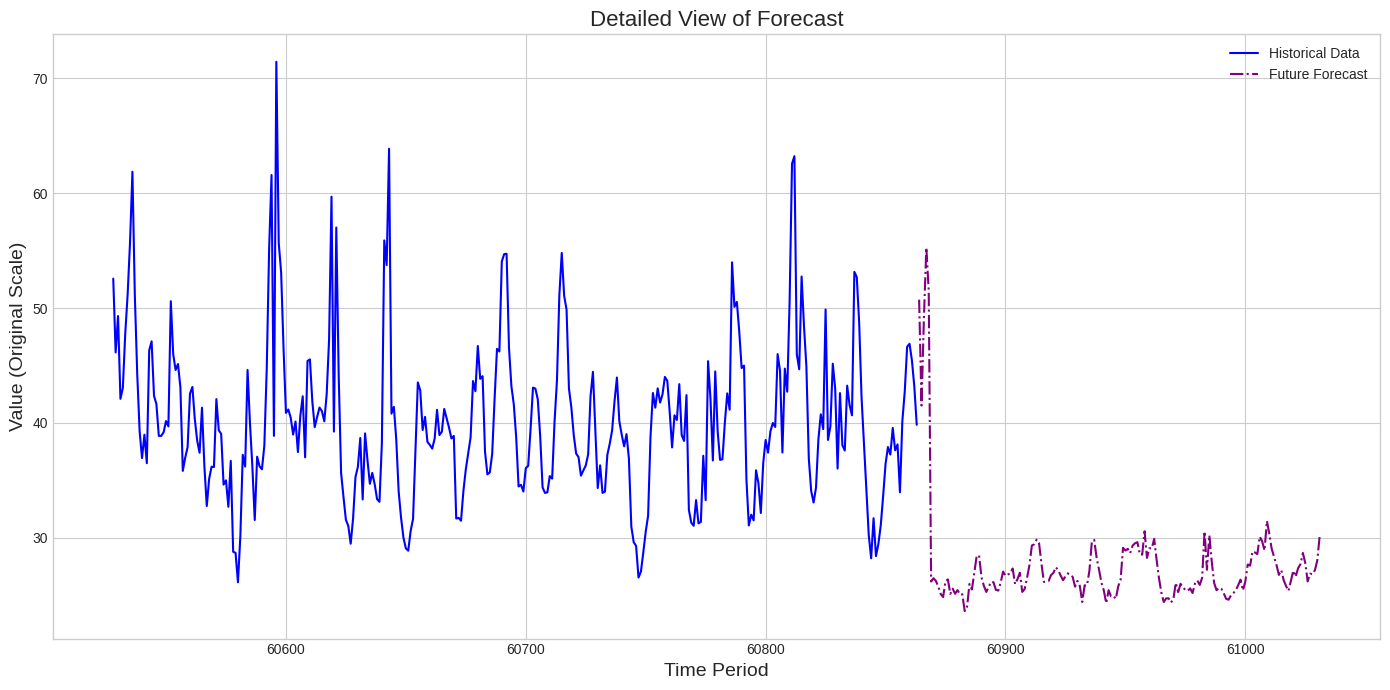

In [ ]:
# Modify the forecast horizon to predict more values
forecast_horizon = 168  # 7 days of hourly data (7*24=168) instead of just 48 hours

# Keep the rest of the forecasting code the same, but make sure you have enough future exogenous data
# If using exogenous variables, you'll need to extend future_exog accordingly
if 'X_test_scaled' in globals() and X_test_scaled is not None:
    # Create more future exogenous data - repeat patterns if needed
    repeats = forecast_horizon // len(X_test_scaled) + 1
    future_exog = np.tile(X_test_scaled, (repeats, 1))[:forecast_horizon]

# Make the longer forecast with the same final model
forecast = final_result.forecast(steps=forecast_horizon, exog=future_exog)
forecast_original = np.exp(forecast) if 'y_train_log' in globals() else forecast

# Update the plot code to show the longer forecast
forecast_start = len(y_train_log) + len(y_test_log) if 'y_test_log' in globals() else len(y_train_log)
forecast_indices = np.arange(forecast_start, forecast_start + forecast_horizon)
plt.figure(figsize=(16, 8))  # Larger figure to accommodate more data

# Add a zoom-in view of the forecast
plt.figure(figsize=(14, 7))
zoom_start = max(0, forecast_start - 336)  # Show 2 weeks of history before forecast
plt.plot(np.arange(zoom_start, forecast_start),
         np.exp(full_history[zoom_start:]) if 'y_train_log' in globals() else full_history[zoom_start:],
         label='Historical Data', color='blue')
plt.plot(forecast_indices, forecast_original, label='Future Forecast', color='purple', linestyle='-.')
plt.title('Detailed View of Forecast', fontsize=16)
plt.xlabel('Time Period', fontsize=14)
plt.ylabel('Value (Original Scale)', fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()


=== Evaluating SARIMA Models (Overall Performance) ===
SARIMA(1, 1, 1)x(0, 0, 0, 24) Performance : 
Training - R²: 0.8358, RMSE: 5.8353, MAPE: 11.98%
Test - R²: 0.5144, RMSE: 8.3035, MAPE: 28.27%
Overall - R²: 0.7910, RMSE: 6.4055, MAPE: 15.24%
Model Information - AIC: 309954.15, BIC: 310050.87
SARIMA(1, 1, 1)x(1, 0, 0, 24) Performance : 
Training - R²: 0.8374, RMSE: 5.8059, MAPE: 11.89%
Test - R²: 0.5233, RMSE: 8.2271, MAPE: 27.22%
Overall - R²: 0.7937, RMSE: 6.3643, MAPE: 14.95%
Model Information - AIC: 309327.10, BIC: 309432.62
SARIMA(1, 1, 1)x(0, 0, 1, 24) Performance : 
Training - R²: 0.8372, RMSE: 5.8100, MAPE: 11.90%
Test - R²: 0.5217, RMSE: 8.2409, MAPE: 27.44%
Overall - R²: 0.7933, RMSE: 6.3709, MAPE: 15.01%
Model Information - AIC: 309390.18, BIC: 309495.69
SARIMA(2, 1, 1)x(0, 0, 0, 24) Performance : 
Training - R²: 0.8384, RMSE: 5.7884, MAPE: 11.89%
Test - R²: 0.4946, RMSE: 8.4713, MAPE: 29.44%
Overall - R²: 0.7904, RMSE: 6.4154, MAPE: 15.40%
Model Information - AIC: 309171

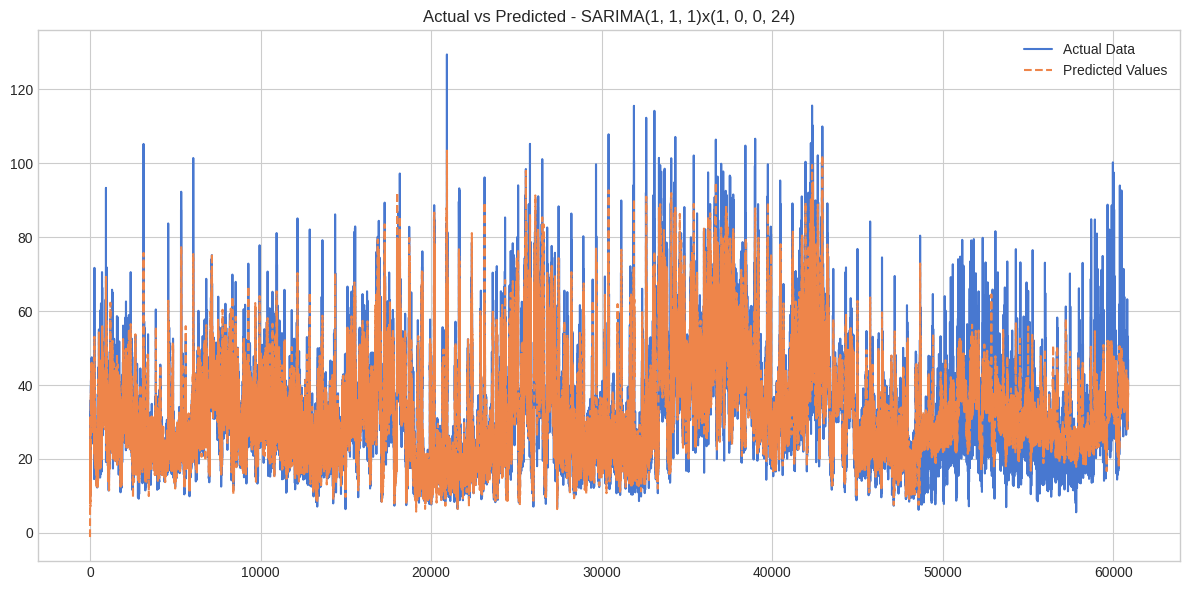

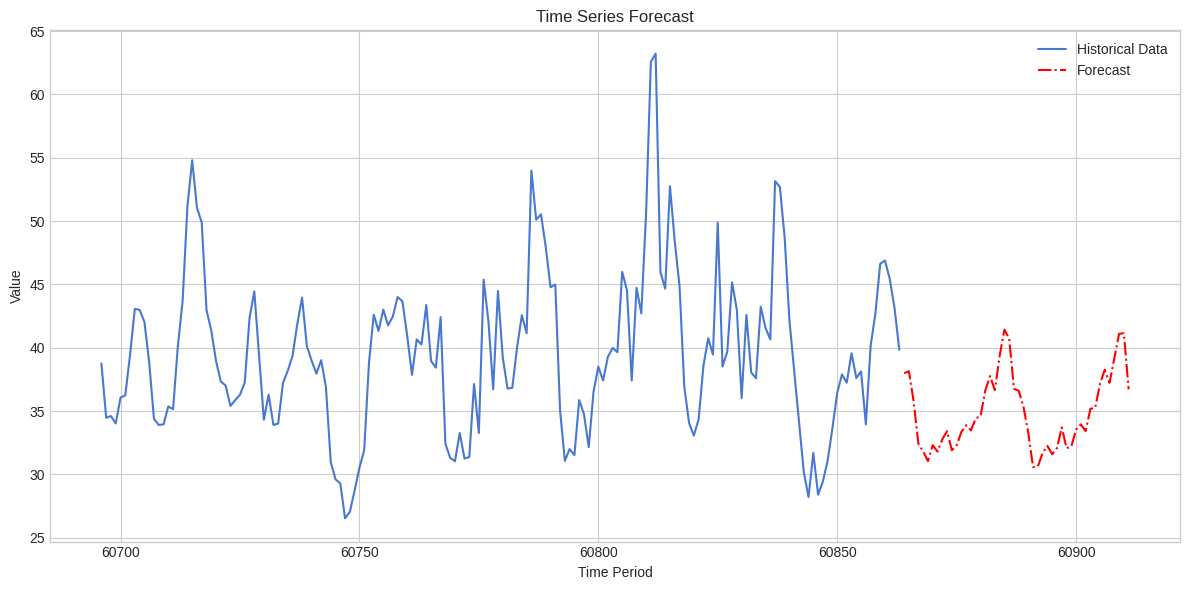


=== Forecast with Prediction Intervals ===
First 5 forecasted values with 95% intervals:
t+1: 37.98 [26.60 - 49.36]
t+2: 38.14 [26.76 - 49.52]
t+3: 35.77 [24.40 - 47.15]
t+4: 32.41 [21.03 - 43.79]
t+5: 31.81 [20.43 - 43.19]


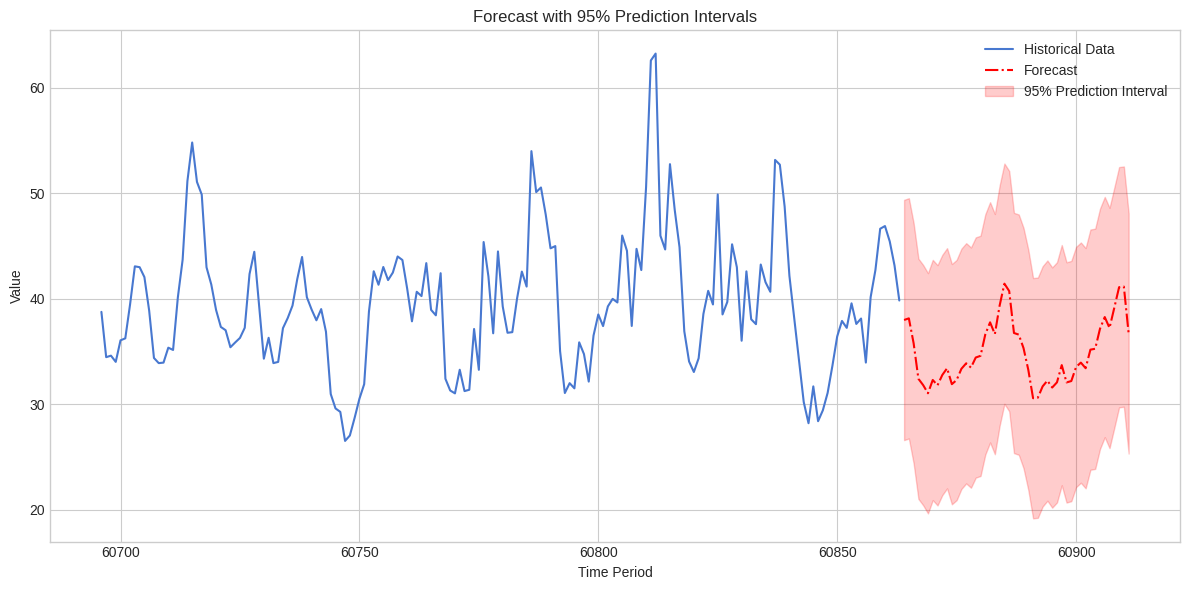


=== Model Summary ===
                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                48691
Model:             SARIMAX(1, 1, 1)x(1, 0, [], 24)   Log Likelihood             -154651.552
Date:                             Mon, 21 Apr 2025   AIC                         309327.104
Time:                                     06:56:19   BIC                         309432.616
Sample:                                          0   HQIC                        309360.196
                                           - 48691                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.4480      0.043     33.923      0.000       1.364       1.532
x2  

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Function to evaluate a SARIMA model with focus on overall performance
def evaluate_sarima(y_data, order, seasonal_order, exog=None, test_size=0.2):
    """
    Fit and evaluate a SARIMA model with given specifications.
    Returns overall performance metrics instead of separate train/test.
    """
    # Split data into train and test
    split_point = int(len(y_data) * (1 - test_size))
    y_train = y_data[:split_point]
    y_test = y_data[split_point:]

    # Split exogenous variables if available
    if exog is not None:
        exog_train = exog[:split_point]
        exog_test = exog[split_point:]
    else:
        exog_train = None
        exog_test = None

    try:
        # Create and fit the model
        model = SARIMAX(
            y_train,
            exog=exog_train,
            order=order,
            seasonal_order=seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False
        )

        result = model.fit(disp=0, maxiter=50, method='powell')

        # Make predictions for both train and test sets
        train_pred = result.predict()
        test_pred = result.predict(
            start=len(y_train),
            end=len(y_train) + len(y_test) - 1,
            exog=exog_test
        )

        # Combine predictions
        all_pred = np.concatenate([train_pred, test_pred])

        #Calculate train set metrics
        train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
        train_r2 = r2_score(y_train, train_pred)
        train_mape = np.mean(np.abs((y_train - train_pred) / y_train)) * 100

        #Calculate test set metrics
        test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
        test_r2 = r2_score(y_test, test_pred)
        test_mape = np.mean(np.abs((y_test - test_pred) / y_test)) * 100

        # Calculate overall performance metrics
        overall_rmse = np.sqrt(mean_squared_error(y_data, all_pred))
        overall_r2 = r2_score(y_data, all_pred)
        overall_mape = np.mean(np.abs((y_data - all_pred) / y_data)) * 100

        print(f"SARIMA{order}x{seasonal_order} Performance : ")
        print(f"Training - R²: {train_r2:.4f}, RMSE: {train_rmse:.4f}, MAPE: {train_mape:.2f}%")
        print(f"Test - R²: {test_r2:.4f}, RMSE: {test_rmse:.4f}, MAPE: {test_mape:.2f}%")
        print(f"Overall - R²: {overall_r2:.4f}, RMSE: {overall_rmse:.4f}, MAPE: {overall_mape:.2f}%")
        print(f"Model Information - AIC: {result.aic:.2f}, BIC: {result.bic:.2f}")

        return {
            'order': order,
            'seasonal_order': seasonal_order,
            'train_metrics': {
                'rmse': train_rmse,
                'r2': train_r2,
                'mape': train_mape
            },
            'test_metrics': {
                'rmse': test_rmse,
                'r2': test_r2,
                'mape': test_mape
            },
            'overall_metrics': {
                'rmse': overall_rmse,
                'r2': overall_r2,
                'mape': overall_mape
            },
            'aic': result.aic,
            'bic': result.bic,
            'model': result,
            'predictions': {
                'train': train_pred,
                'test': test_pred,
                'all': all_pred
            }
        }

    except Exception as e:
        print(f"Error fitting SARIMA{order}x{seasonal_order}: {str(e)}")
        return None


# If you're working with logged data, transform back to original scale
if 'y_train_log' in globals() and 'y_test_log' in globals():
    y_data = np.exp(np.concatenate([y_train_log, y_test_log]))
    if 'X_train_scaled' in globals() and 'X_test_scaled' in globals():
        exog = np.vstack([X_train_scaled, X_test_scaled])
    else:
        exog = None
else:
    print("Please provide data by uncommenting and modifying the data loading code")
    y_data = None
    exog = None

if y_data is not None:
    # Define a small set of promising models to try
    models_to_try = [
        # Format: (p,d,q), (P,D,Q,s)
        ((1,1,1), (0,0,0,24)),  # Base model
        ((1,1,1), (1,0,0,24)),  # Add seasonal AR
        ((1,1,1), (0,0,1,24)),  # Add seasonal MA
        ((2,1,1), (0,0,0,24)),  # Increase AR order
        ((1,1,2), (0,0,0,24))   # Increase MA order
    ]

    # Evaluate models
    results = []
    print("\n=== Evaluating SARIMA Models (Overall Performance) ===")
    for order, seasonal_order in models_to_try:
        result = evaluate_sarima(y_data, order, seasonal_order, exog=exog)
        if result:
            results.append(result)

    # Find the best-performing model based on R²
    if results:
        # Sort by R² (higher is better)
        results.sort(key=lambda x: x['overall_metrics']['r2'], reverse=True)
        best_model = results[0]

        print("\n=== Best Model ===")
        print(f"SARIMA{best_model['order']}x{best_model['seasonal_order']}")
        print(f"Overall R²: {best_model['overall_metrics']['r2']:.4f}")
        print(f"Overall RMSE: {best_model['overall_metrics']['rmse']:.4f}")
        print(f"Overall MAPE: {best_model['overall_metrics']['mape']:.2f}%")
        print(f"AIC: {best_model['aic']:.2f}")
        print(f"BIC: {best_model['bic']:.2f}")

        # Plot actual vs. predicted
        plt.figure(figsize=(12, 6))
        plt.plot(y_data, label='Actual Data')
        plt.plot(best_model['predictions']['all'], label='Predicted Values', linestyle='--')
        plt.title(f'Actual vs Predicted - SARIMA{best_model["order"]}x{best_model["seasonal_order"]}')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig('sarima_prediction.png')
        plt.show()

        # Make future forecasts
        forecast_steps = 48  # 2 days of hourly data

        # For exogenous variables in forecast period, we'll repeat the last cycle
        if exog is not None:
            cycle_length = 24  # Assuming daily cycle for hourly data
            last_exog_cycle = exog[-cycle_length:]
            repeats_needed = (forecast_steps // cycle_length) + 1
            future_exog = np.tile(last_exog_cycle, (repeats_needed, 1))[:forecast_steps]
        else:
            future_exog = None

        # Generate forecast
        forecast = best_model['model'].forecast(steps=forecast_steps, exog=future_exog)

        # Plot forecast
        plt.figure(figsize=(12, 6))

        # Show last 7 days of actual data
        history_points = 7 * 24  # 7 days of hourly data
        history_start = max(0, len(y_data) - history_points)

        plt.plot(range(history_start, len(y_data)), y_data[history_start:], label='Historical Data')
        plt.plot(range(len(y_data), len(y_data) + forecast_steps), forecast,
                label='Forecast', color='red', linestyle='-.')

        plt.title('Time Series Forecast')
        plt.xlabel('Time Period')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig('sarima_forecast.png')
        plt.show()

        # Calculate prediction intervals
        try:
            # Use residual standard deviation for prediction intervals
            residuals = best_model['model'].resid
            residual_std = np.std(residuals)

            # 95% prediction interval (±1.96 standard deviations)
            lower_bound = forecast - 1.96 * residual_std
            upper_bound = forecast + 1.96 * residual_std

            # Ensure lower bound isn't negative for positive data
            if np.min(y_data) >= 0:
                lower_bound = np.maximum(0, lower_bound)

            print("\n=== Forecast with Prediction Intervals ===")
            print("First 5 forecasted values with 95% intervals:")
            for i in range(5):
                print(f"t+{i+1}: {forecast[i]:.2f} [{lower_bound[i]:.2f} - {upper_bound[i]:.2f}]")

            # Plot forecast with intervals
            plt.figure(figsize=(12, 6))
            plt.plot(range(history_start, len(y_data)), y_data[history_start:], label='Historical Data')
            plt.plot(range(len(y_data), len(y_data) + forecast_steps), forecast,
                    label='Forecast', color='red', linestyle='-.')
            plt.fill_between(
                range(len(y_data), len(y_data) + forecast_steps),
                lower_bound, upper_bound,
                color='red', alpha=0.2, label='95% Prediction Interval'
            )

            plt.title('Forecast with 95% Prediction Intervals')
            plt.xlabel('Time Period')
            plt.ylabel('Value')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.savefig('sarima_forecast_intervals.png')
            plt.show()

        except Exception as e:
            print(f"Could not generate prediction intervals: {str(e)}")

        # Model summary
        print("\n=== Model Summary ===")
        print(best_model['model'].summary())

    else:
        print("No successful models found. Try simpler specifications or check your data.")
else:
    print("No data available for modeling.")

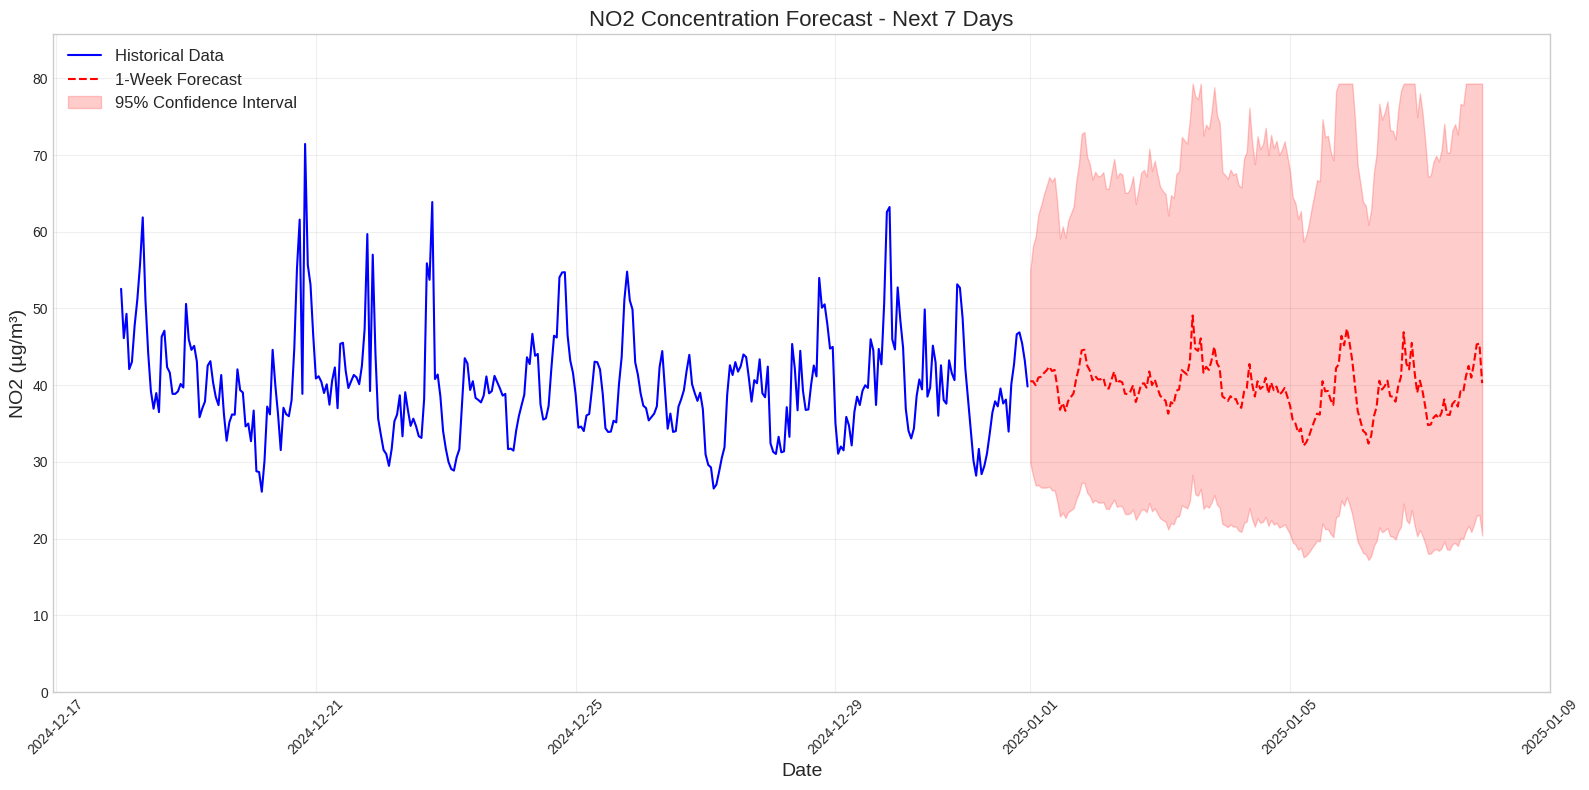


First 24 hours of forecast:
                     NO2_Forecast  Lower_CI  Upper_CI
Timestamp                                            
2025-01-01 00:00:00         40.51     29.88     54.93
2025-01-01 01:00:00         40.51     28.23     58.13
2025-01-01 02:00:00         39.99     26.93     59.40
2025-01-01 03:00:00         40.99     26.99     62.26
2025-01-01 04:00:00         41.11     26.65     63.42
2025-01-01 05:00:00         41.56     26.65     64.82
2025-01-01 06:00:00         41.91     26.65     65.91
2025-01-01 07:00:00         42.42     26.80     67.12
2025-01-01 08:00:00         41.84     26.31     66.55
2025-01-01 09:00:00         41.99     26.29     67.06
2025-01-01 10:00:00         39.74     24.80     63.68
2025-01-01 11:00:00         36.79     22.89     59.12
2025-01-01 12:00:00         37.67     23.38     60.71
2025-01-01 13:00:00         36.65     22.69     59.19
2025-01-01 14:00:00         37.95     23.44     61.42
2025-01-01 15:00:00         38.43     23.70     62.34

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

## 1. Prepare the Final Model with All Available Data

# Combine training and test data
full_history = np.concatenate([y_train_log, y_test_log])
full_exog = np.vstack([X_train_scaled, X_test_scaled])

# Fit final model on all data
final_model = SARIMAX(
    full_history,
    exog=full_exog,
    order=(1,1,1),         # Your best order (p,d,q)
    seasonal_order=(1,0,0,24),  # Your best seasonal order
    enforce_stationarity=False,
    enforce_invertibility=False
)

# final_result = final_model.fit(disp=0, method='powell')
final_result = final_model.fit(
    disp=1,
    method='nm',            # Nelder-Mead method
    maxiter=200,            # Increased iterations
    start_params=None,      # Let the algorithm choose initial params
    # Add these critical parameters:
    approximate_diffuse=True,  # Better initialization
    simple_differencing=True   # Faster numerical processing
)


# Forecast horizon (7 days * 24 hours = 168 hours)
forecast_horizon = 168

# Create future exogenous variables by repeating the last weekly cycle
# This assumes your exogenous variables follow a weekly pattern
last_week = full_exog[-168:] if len(full_exog) >= 168 else full_exog[-24:] * 7
future_exog = last_week[:forecast_horizon]

## 3. Generate Forecast and Confidence Intervals

# Get forecast with 95% confidence intervals
forecast_result = final_result.get_forecast(
    steps=forecast_horizon,
    exog=future_exog
)

# Extract results
forecast = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

# Convert from log scale back to original scale
forecast_original = np.exp(forecast)
lower_bound = np.exp(conf_int[:, 0])  # Fixed: use iloc and correct column
upper_bound = np.exp(conf_int[:, 1])  # Fixed: use correct column for upper bound

## 4. Create Forecast DataFrame

# Generate future timestamps
last_timestamp = df_processed.index[-1]
forecast_dates = pd.date_range(
    start=last_timestamp + pd.Timedelta(hours=1),
    periods=forecast_horizon,
    freq='H'
)

# Create results DataFrame
forecast_df = pd.DataFrame({
    'Timestamp': forecast_dates,
    'NO2_Forecast': forecast_original,
    'Lower_CI': lower_bound,
    'Upper_CI': upper_bound
}).set_index('Timestamp')

## 5. Visualize the Forecast

plt.figure(figsize=(16, 8))

# Plot last 2 weeks of actual data
history_days = 14  # Show 2 weeks of history
history_start = max(0, len(full_history) - history_days*24)
history_dates = df_processed.index[history_start:]
history_values = np.exp(full_history[history_start:])

plt.plot(history_dates, history_values,
         label='Historical Data', color='blue')

# Plot forecast
plt.plot(forecast_df.index, forecast_df['NO2_Forecast'],
         label='1-Week Forecast', color='red', linestyle='--')

# Plot confidence intervals - with reasonable max cap to prevent extreme values
plt.fill_between(forecast_df.index,
                 forecast_df['Lower_CI'],
                 np.minimum(forecast_df['Upper_CI'], forecast_original.mean() * 2),  # Cap the upper bound
                 color='red', alpha=0.2, label='95% Confidence Interval')

# Formatting
plt.title('NO2 Concentration Forecast - Next 7 Days', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('NO2 (µg/m³)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.ylim(bottom=0, top=max(history_values.max() * 1.2, forecast_original.max() * 1.2))  # Set reasonable y-axis limits

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('weekly_forecast.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. Save Forecast Results

# Save to CSV
forecast_df.to_csv('no2_weekly_forecast.csv')

# Print first few forecasted values
print("\nFirst 24 hours of forecast:")
print(forecast_df.head(24).round(2))

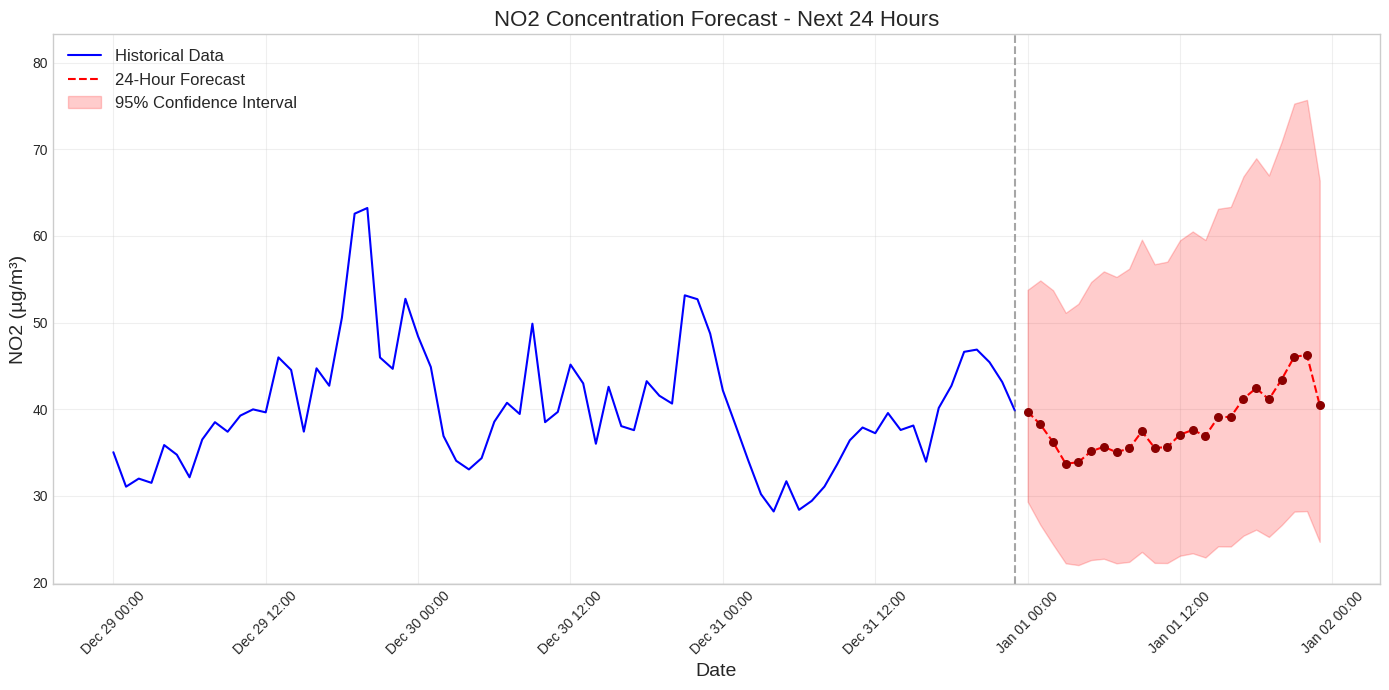


24-hour NO2 concentration forecast:
                     NO2_Forecast  Lower_CI  Upper_CI
Timestamp                                            
2025-01-01 00:00:00         39.72     29.34     53.78
2025-01-01 01:00:00         38.25     26.66     54.86
2025-01-01 02:00:00         36.21     24.40     53.73
2025-01-01 03:00:00         33.71     22.22     51.13
2025-01-01 04:00:00         33.89     22.02     52.17
2025-01-01 05:00:00         35.15     22.60     54.68
2025-01-01 06:00:00         35.66     22.75     55.91
2025-01-01 07:00:00         35.04     22.22     55.26
2025-01-01 08:00:00         35.48     22.39     56.22
2025-01-01 09:00:00         37.45     23.54     59.57
2025-01-01 10:00:00         35.54     22.27     56.73
2025-01-01 11:00:00         35.62     22.25     57.03
2025-01-01 12:00:00         37.07     23.10     59.50
2025-01-01 13:00:00         37.61     23.38     60.51
2025-01-01 14:00:00         36.92     22.90     59.53
2025-01-01 15:00:00         39.07     24.18  

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

## 1. Prepare the Final Model with All Available Data

# Combine training and test data
full_history = np.concatenate([y_train_log, y_test_log])
full_exog = np.vstack([X_train_scaled, X_test_scaled])

# Fit final model on all data
final_model = SARIMAX(
    full_history,
    exog=full_exog,
    order=(1,1,1),         # Your best order (p,d,q)
    seasonal_order=(1,0,0,24),  # Your best seasonal order
    enforce_stationarity=False,
    enforce_invertibility=False
)

final_result = final_model.fit(disp=0, method='powell', maxiter=50)

## 2. Prepare Exogenous Variables for 24-hour Forecast Period

# Forecast horizon (24 hours)
forecast_horizon = 24

# Create future exogenous variables using the last day's pattern
last_day = full_exog[-24:]  # Last 24 hours of exogenous data
future_exog = last_day[:forecast_horizon]

## 3. Generate Forecast and Confidence Intervals

# Get forecast with 95% confidence intervals
forecast_result = final_result.get_forecast(
    steps=forecast_horizon,
    exog=future_exog
)

# Extract results
forecast = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

# Convert from log scale back to original scale
forecast_original = np.exp(forecast)
lower_bound = np.exp(conf_int[:, 0])
upper_bound = np.exp(conf_int[:, 1])

## 4. Create Forecast DataFrame

# Generate future timestamps
last_timestamp = df_processed.index[-1]
forecast_dates = pd.date_range(
    start=last_timestamp + pd.Timedelta(hours=1),
    periods=forecast_horizon,
    freq='H'
)

# Create results DataFrame
forecast_df = pd.DataFrame({
    'Timestamp': forecast_dates,
    'NO2_Forecast': forecast_original,
    'Lower_CI': lower_bound,
    'Upper_CI': upper_bound
}).set_index('Timestamp')

## 5. Visualize the Forecast

plt.figure(figsize=(14, 7))

# Plot the last 3 days of historical data for context
history_days = 3  # Show 3 days of history
history_start = max(0, len(full_history) - history_days*24)
history_dates = df_processed.index[history_start:]
history_values = np.exp(full_history[history_start:])

plt.plot(history_dates, history_values,
         label='Historical Data', color='blue')

# Plot 24-hour forecast
plt.plot(forecast_df.index, forecast_df['NO2_Forecast'],
         label='24-Hour Forecast', color='red', linestyle='--')

# Plot confidence intervals
plt.fill_between(forecast_df.index,
                 forecast_df['Lower_CI'],
                 forecast_df['Upper_CI'],
                 color='red', alpha=0.2, label='95% Confidence Interval')

# Add markers for hourly points to make them more visible
plt.scatter(forecast_df.index, forecast_df['NO2_Forecast'],
            color='darkred', s=30, zorder=5)

# Formatting
plt.title('NO2 Concentration Forecast - Next 24 Hours', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('NO2 (µg/m³)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

# Set reasonable y-axis limits
max_value = max(history_values.max(), upper_bound.max())
min_value = min(history_values.min(), lower_bound.min())
plt.ylim(bottom=max(0, min_value * 0.9), top=max_value * 1.1)

# Format x-axis to show hours more clearly
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b %d %H:%M'))
plt.xticks(rotation=45)

# Add vertical line separating historical data from forecast
plt.axvline(x=last_timestamp, color='gray', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('24hr_forecast.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. Save Forecast Results

# Save to CSV
forecast_df.to_csv('no2_24hr_forecast.csv')

# Print forecasted values
print("\n24-hour NO2 concentration forecast:")
print(forecast_df.round(2))

# Calculate summary statistics
print("\nSummary Statistics:")
print(f"Mean forecast: {forecast_df['NO2_Forecast'].mean():.2f} µg/m³")
print(f"Min forecast: {forecast_df['NO2_Forecast'].min():.2f} µg/m³")
print(f"Max forecast: {forecast_df['NO2_Forecast'].max():.2f} µg/m³")
print(f"Expected peak time: {forecast_df['NO2_Forecast'].idxmax()}")


=== Fold 1/5 ===
Train: 2018-01-22 00:00:00 to 2024-11-26 23:00:00
Test:  2024-11-27 00:00:00 to 2024-12-03 23:00:00
  Fit time: 158.7s | RMSE: 15.03 | MAPE: 42.48% | R²: -0.867

=== Fold 2/5 ===
Train: 2018-01-22 00:00:00 to 2024-12-03 23:00:00
Test:  2024-12-04 00:00:00 to 2024-12-10 23:00:00
  Fit time: 158.1s | RMSE: 4.85 | MAPE: 15.23% | R²: 0.389

=== Fold 3/5 ===
Train: 2018-01-22 00:00:00 to 2024-12-10 23:00:00
Test:  2024-12-11 00:00:00 to 2024-12-17 23:00:00
  Fit time: 157.7s | RMSE: 13.80 | MAPE: 18.02% | R²: 0.032

=== Fold 4/5 ===
Train: 2018-01-22 00:00:00 to 2024-12-17 23:00:00
Test:  2024-12-18 00:00:00 to 2024-12-24 23:00:00
  Fit time: 157.9s | RMSE: 11.10 | MAPE: 28.17% | R²: -1.261

=== Fold 5/5 ===
Train: 2018-01-22 00:00:00 to 2024-12-24 23:00:00
Test:  2024-12-25 00:00:00 to 2024-12-31 23:00:00
  Fit time: 158.6s | RMSE: 5.32 | MAPE: 10.49% | R²: 0.298

=== Cross-Validation Summary ===
Successful folds: 5/5
Mean RMSE: 10.02
Mean MAPE: 22.88%
Mean R²: -0.282
Mea

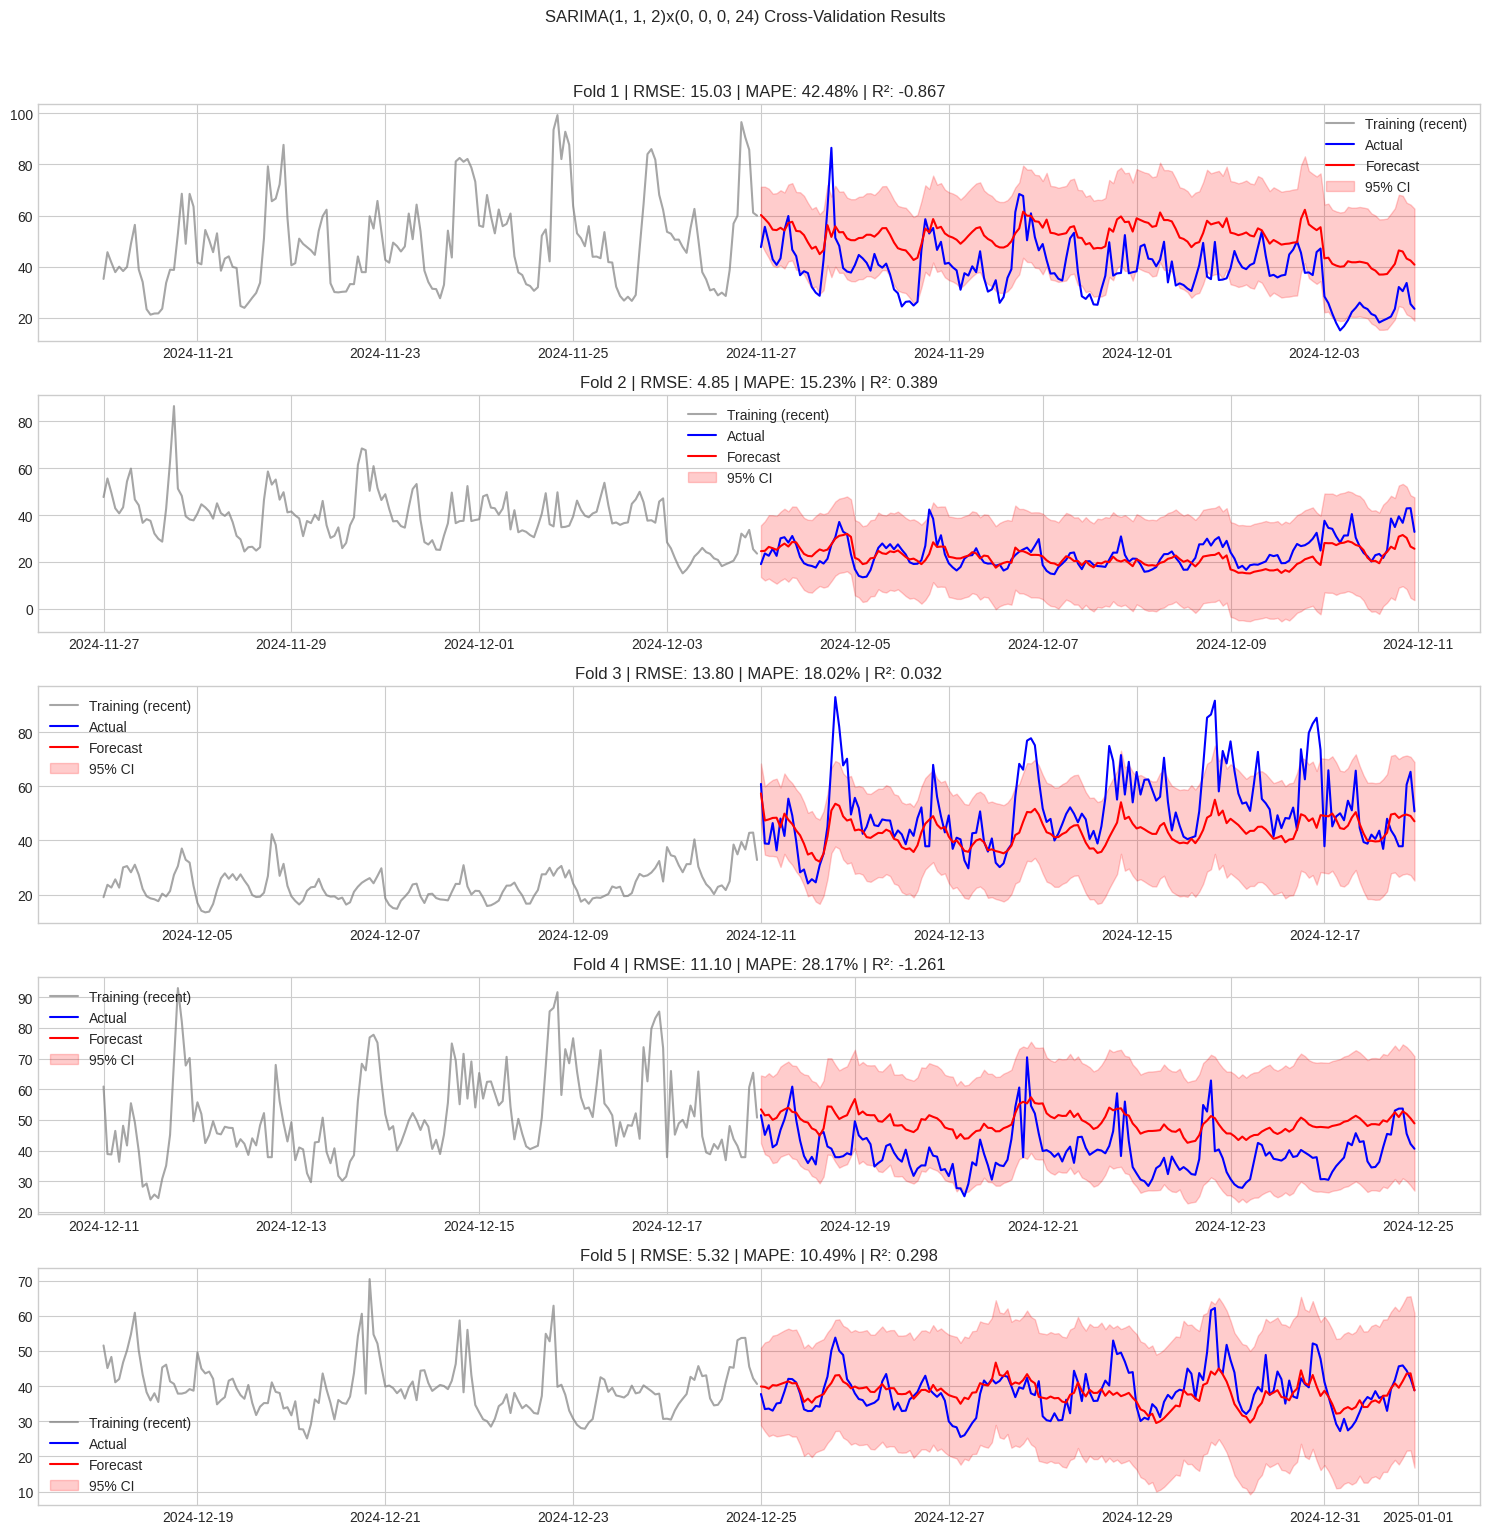


Final CV Results:
Average R²: -0.282
Average RMSE: 10.02
Average MAPE: 22.88%
Success rate: 100%


In [ ]:
import time
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore')

def robust_sarima_cv(series, exog=None, order=(1,1,1), seasonal_order=(1,0,0,24),
                     n_splits=5, test_size=24, forecast_horizon=None,
                     plot_results=True, verbose=True):

    # Set forecast horizon to test_size if not specified
    if forecast_horizon is None:
        forecast_horizon = test_size

    # Ensure series is a pandas Series with datetime index
    if not isinstance(series, pd.Series):
        try:
            series = pd.Series(series)
        except:
            raise TypeError("Input must be convertible to pandas Series")

    # Initialize metrics storage
    metrics = {
        'rmse': [],
        'mape': [],
        'r2': [],
        'fit_time': [],
        'success': []
    }

    # Create time series splits
    tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size)

    # Setup plotting if requested
    if plot_results:
        fig, axes = plt.subplots(n_splits, 1, figsize=(15, n_splits * 3))
        if n_splits == 1:
            axes = [axes]  # Ensure axes is a list for consistent indexing
        plt.suptitle(f"SARIMA{order}x{seasonal_order} Cross-Validation Results", y=1.02)

    # Perform cross-validation
    for fold, (train_idx, test_idx) in enumerate(tscv.split(series)):
        if verbose:
            print(f"\n=== Fold {fold+1}/{n_splits} ===")
            print(f"Train: {series.index[train_idx[0]]} to {series.index[train_idx[-1]]}")
            print(f"Test:  {series.index[test_idx[0]]} to {series.index[test_idx[-1]]}")

        # Extract train and test data
        train_data = series.iloc[train_idx]
        test_data = series.iloc[test_idx]

        # Extract exogenous variables if provided
        train_exog = exog[train_idx] if exog is not None else None
        test_exog = exog[test_idx] if exog is not None else None

        try:
            # Time the model fitting
            start_time = time.time()

            # Create and fit the model
            model = SARIMAX(
                train_data,
                exog=train_exog,
                order=order,
                seasonal_order=seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False
            )

            # Fit with sensible defaults to avoid common convergence issues
            model_fit = model.fit(
                disp=0,              # No convergence display
                method='powell',     # Powell is often more stable than BFGS
                maxiter=50,         # Reasonable number of iterations
            )

            fit_time = time.time() - start_time

            # Generate forecast
            forecast = model_fit.get_forecast(steps=len(test_data), exog=test_exog)
            pred_mean = forecast.predicted_mean

            # Calculate metrics
            # Handle potential mismatch in index
            if isinstance(pred_mean, pd.Series):
                pred_values = pred_mean.values
            else:
                pred_values = pred_mean

            test_values = test_data.values

            # RMSE
            rmse = sqrt(mean_squared_error(test_values, pred_values))

            # MAPE (with handling for zeros)
            try:
                mape = mean_absolute_percentage_error(test_values, pred_values) * 100
            except:
                # Fallback calculation
                with np.errstate(divide='ignore', invalid='ignore'):
                    mape = np.abs((test_values - pred_values) / np.where(test_values != 0, test_values, np.nan))
                    mape = np.nanmean(mape) * 100

            # R²
            r2 = r2_score(test_values, pred_values)

            # Store metrics
            metrics['rmse'].append(rmse)
            metrics['mape'].append(mape)
            metrics['r2'].append(r2)
            metrics['fit_time'].append(fit_time)
            metrics['success'].append(True)

            if verbose:
                print(f"  Fit time: {fit_time:.1f}s | RMSE: {rmse:.2f} | "
                      f"MAPE: {mape:.2f}% | R²: {r2:.3f}")

            # Plot results if requested
            if plot_results:
                ax = axes[fold]

                # Plot training data (last week, or less if not available)
                lookback = min(7*24, len(train_data))
                ax.plot(train_data.index[-lookback:], train_data[-lookback:],
                       label='Training (recent)', color='gray', alpha=0.7)

                # Plot test data and forecast
                ax.plot(test_data.index, test_data, label='Actual', color='blue')
                ax.plot(test_data.index, pred_mean, label='Forecast', color='red')

                # Add confidence intervals if available
                try:
                    conf_int = forecast.conf_int()
                    ax.fill_between(test_data.index,
                                  conf_int.iloc[:, 0],
                                  conf_int.iloc[:, 1],
                                  color='red', alpha=0.2, label='95% CI')
                except Exception as e:
                    if verbose:
                        print(f"  Warning: Could not plot confidence intervals: {str(e)}")

                # Add title and legend
                ax.set_title(f"Fold {fold+1} | RMSE: {rmse:.2f} | MAPE: {mape:.2f}% | R²: {r2:.3f}")
                ax.legend()
                ax.grid(True)

        except Exception as e:
            metrics['success'].append(False)
            if verbose:
                print(f"  ⚠️ Fold {fold+1} failed: {str(e)}")
                # Store NaN for failed folds
                metrics['rmse'].append(np.nan)
                metrics['mape'].append(np.nan)
                metrics['r2'].append(np.nan)
                metrics['fit_time'].append(np.nan)

    # Calculate average metrics (only for successful folds)
    success_mask = np.array(metrics['success'])
    avg_metrics = {}

    if np.any(success_mask):
        for key in ['rmse', 'mape', 'r2', 'fit_time']:
            avg_metrics[key] = np.nanmean(np.where(success_mask, metrics[key], np.nan))
    else:
        avg_metrics = {key: np.nan for key in ['rmse', 'mape', 'r2', 'fit_time']}

    # Print summary
    if verbose:
        print("\n=== Cross-Validation Summary ===")
        print(f"Successful folds: {np.sum(success_mask)}/{n_splits}")
        print(f"Mean RMSE: {avg_metrics['rmse']:.2f}")
        print(f"Mean MAPE: {avg_metrics['mape']:.2f}%")
        print(f"Mean R²: {avg_metrics['r2']:.3f}")
        print(f"Mean fit time: {avg_metrics['fit_time']:.1f}s")

    # Finalize plot
    if plot_results:
        plt.tight_layout()
        plt.savefig('sarima_cv_results.png', dpi=100, bbox_inches='tight')
        plt.show()

    # Return both individual fold metrics and averages
    return {
        'individual': pd.DataFrame(metrics),
        'average': avg_metrics,
        'success_rate': np.mean(success_mask)
    }

# Example usage with your data
def run_sarima_cv(df_processed, target_col, exog_features=None,
                  order=(1,1,1), seasonal_order=(1,0,0,24),
                  n_splits=5, test_size=24*7):


    try:
        # Prepare data
        y = df_processed[target_col]
        X = df_processed[exog_features].values if exog_features else None

        cv_results = robust_sarima_cv(
            series=y,
            exog=X,
            order=order,
            seasonal_order=seasonal_order,
            n_splits=n_splits,
            test_size=test_size,
            plot_results=True,
            verbose=True
        )
        return cv_results
    except Exception as e:
        print(f"Error during cross-validation: {str(e)}")
        return None

# Run the cross-validation on your data
cv_results = run_sarima_cv(
    df_processed=df_processed,
    target_col=target_col,
    exog_features=selected_features,  # Your selected features
    order=(1, 1, 1),                # ARIMA order
    seasonal_order=(1, 0, 0, 24),    # Seasonal order
    n_splits=5,                      # Number of folds
    test_size=24*7                   # 1 week test size
)

if cv_results:
    print("\nFinal CV Results:")
    print(f"Average R²: {cv_results['average']['r2']:.3f}")
    print(f"Average RMSE: {cv_results['average']['rmse']:.2f}")
    print(f"Average MAPE: {cv_results['average']['mape']:.2f}%")
    print(f"Success rate: {cv_results['success_rate']:.0%}")